# Agent with Basic Functionality and Configuration

## References 

https://www.youtube.com/watch?v=hvAPnpSfSGo


## States

In [24]:
import operator
from dataclasses import dataclass
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

from pydantic import BaseModel, Field


# TODO: separate input and output schemas
@dataclass
class InputPlanningState(TypedDict):
    pass


@dataclass
class PlanningState(TypedDict):
    """State of conversation between Agent and User."""

    project_description: Annotated[
        str, "Description of the project"
    ]  # Initial idea/explaination of the project
    messages: Annotated[
        list[str], add_messages
    ]  # Clarifying questions to refine the project idea

    project_plan: Annotated[list[str], operator.add]  # generated by Agent/s


class SearchQuery(BaseModel):
    """Agent will use this to search for information."""

    query: str = Field(..., description="The query to search for")


## Strategy Pattern for Model Providers

In [25]:
from abc import ABC, abstractmethod
from typing import Any

from langchain_core.language_models.chat_models import BaseChatModel
from langchain_openai import ChatOpenAI


class LLMProvider(ABC):
    """Abstract base class for LLM providers."""

    def __init__(self) -> None:
        """Initialize the LLM provider."""
        self.llm = None

    @abstractmethod
    def _create_llm_instance(self) -> BaseChatModel:
        """Abstract method to create LLM instance.

        This must be implemented by subclasses/Providers.
        """
        raise NotImplementedError

    def __getattr__(self, name: str) -> Any:
        """Delegate attribute access to the underlying LLM instance.

        This is the magic that allows us to call methods like `invoke`,
        `stream`, etc., directly on an `LLMProvider` instance, and they
        will be forwarded to the actual `self.llm` object (e.g., ChatOpenAI).
        """
        if self.llm is None:
            raise AttributeError(
                f"'{self.__class__.__name__}' has no LLM instance. The LLM client may not be initialized yet."
            )
        return getattr(self.llm, name)


class OpenAIProvider(LLMProvider):
    """Concrete LLM provider for OpenAI models."""

    def __init__(
        self, model_name: str = "gpt-4o", temperature: float = 0.0, **kwargs
    ) -> ChatOpenAI:
        """Initialize the OpenAIProvider."""
        self.model_name = model_name
        self.temperature = temperature
        self.kwargs = kwargs
        self.llm = self._create_llm_instance()

    def _create_llm_instance(self) -> BaseChatModel:
        """Concrete LLM provider for OpenAI models."""
        try:
            return ChatOpenAI(
                model=self.model_name, temperature=self.temperature, **self.kwargs
            )
        except Exception as e:
            raise RuntimeError(f"Failed to create ChatOpenAI instance: {e}")


## Create a Web Search Tool

In [42]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_tavily import TavilySearch
from langchain_core.tools import tool


# Search query writing
SEARCH_INSTRUCTIONS = SystemMessage(
    content="""You have given a project idea:{project_description} to develop well structured project plan.
    you can search web for more information about this project idea and required tools or frameworks.
    prepare a well-strructured search query to search web for more information about this project idea and required tools or frameworks.
    """
)
tavily_search = TavilySearch(max_results=3)


@tool
def search_web(state: PlanningState) -> PlanningState:
    """Retrieve information from the web."""
    print("#### search_web ####")
    structured_llm = llm.with_structured_output(SearchQuery)
    project_description = state.project_description
    search_query: SearchQuery = structured_llm.invoke(
        [SEARCH_INSTRUCTIONS.format(project_idea=project_description)]
        + state["messages"]
    )
    search_docs = tavily_search.invoke(search_query.query)
    # format
    formatted_search_docs = "\n\n--\n\n".join(
        [
            f"""<Document href='{doc["url"]}'messages/>\n{doc["content"]}\n<Document>"""
            for doc in search_docs
        ]
    )
    state["project_plan"] = [formatted_search_docs]
    return state


@tool
def search_wikipedia(state: PlanningState) -> PlanningState:
    """Retrieve information from Wikipedia."""
    structured_llm = llm.with_structured_output(SearchQuery)

    project_description = state.project_description

    search_query: SearchQuery = structured_llm.invoke(
        [SEARCH_INSTRUCTIONS.format(project_description=project_description)]
        + state["messages"]
    )
    search_docs = tavily_search.invoke(search_query.query)
    # format
    formatted_search_docs = "\n\n--\n\n".join(
        [
            f"""<Document href='{doc["url"]}'/>\n{doc["content"]}\n<Document>"""
            for doc in search_docs
        ]
    )
    state.project_plan = [formatted_search_docs]
    return state


#  TODO: add Python tool

TOOLS = [search_wikipedia]  # search_wikipedia]

In [43]:
# search_web.invoke(PlanningState(project_description="I want to build a chatbot"))

In [44]:
# TODO: add router function to route between tools and llm or end

## Graph

topic -> agent -> tools -> 

In [45]:
llm = OpenAIProvider()

SYSTEM_PROMPT = """ You are an Expert Software Engineer and Project Manager.
    You have given a project initial project description: "{project_description}" to develop well structured project plan.
    you can search web for more information about this project idea and required tools or frameworks. you can ask me for more information or clearification regarding the project.
    I can help me make more clean decision regarding planning.
    
    """
SYSTEM_PROMPT_PROJECT_PLAN_STRUCTURE = """ here is the reseach information about the project plan details: {project_plan}
     you can submit the final project plan details in markdown format. """


def call_agent_model(state: PlanningState) -> dict[str, Any]:
    """Call the primary Language Model (LLM) to decide on the next research action.

    This asynchronous function performs the following steps:
    1. Initializes configuration and sets up the 'Info' tool, which is the user-defined extraction schema.
    2. Prepares the prompt and message history for the LLM.
    3. Initializes and configures the LLM with available tools.
    4. Invokes the LLM and processes its response.
    5. Handles the LLM's decision to either continue research or submit final info.
    """
    # Load configuration

    # Define

    project_description = state["project_description"][0].content
    # Prepare prompt and message history
    prompt = SYSTEM_PROMPT.format(project_description=project_description)
    # print(prompt)
    message_history = [SystemMessage(content=prompt)] + state["messages"]

    # Initialize and configure LLM with available tools
    llm_with_tools = llm.bind_tools(TOOLS)

    # Invoke LLM and process response
    response = llm_with_tools.invoke(message_history)
    print(response.content)
    return {"messages": response}


def genereate_plan(state: PlanningState):
    messages = state["messages"]
    project_plan = state.get("project_plan", "")

    system_message = SYSTEM_PROMPT_PROJECT_PLAN_STRUCTURE.format(
        project_plan=project_plan
    )
    messages = [SystemMessage(content=system_message)] + messages

    result = llm.invoke(messages)
    return {"project_plan": [result]}


def should_continue(state: PlanningState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    else:
        return "generate_plan"

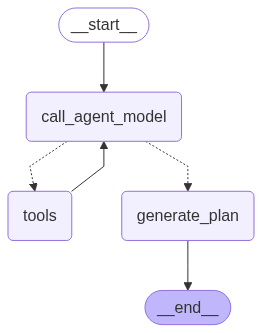

In [46]:
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph(PlanningState)  # , config_schema=Configuration)

builder.add_node("call_agent_model", call_agent_model)
builder.add_node("tools", ToolNode(TOOLS))
builder.add_node("generate_plan", genereate_plan)
builder.add_edge(START, "call_agent_model")
builder.add_conditional_edges(
    "call_agent_model",
    should_continue,
    ["tools", "generate_plan"],
)
builder.add_edge("tools", "call_agent_model")
# builder.add_edge("call_agent_model", "generate_plan")
builder.add_edge("generate_plan", END)


graph = builder.compile(name="Planning Agent")
graph

In [ ]:
messages = [
    HumanMessage(
        content="help me to develop a plan for developing project planning ai agent using Langgraph"
    )
]
messages = graph.invoke({"project_description": messages})


To develop a project plan for creating a project planning AI agent using Langggraph, we need to consider several aspects such as understanding the capabilities of Langggraph, defining the scope of the AI agent, identifying the necessary tools and technologies, and outlining the development phases.

Here's a preliminary outline for the project plan:

1. **Project Overview**
   - Define the purpose and objectives of the AI agent.
   - Identify the target users and their needs.

2. **Research and Analysis**
   - Investigate Langggraph's features and capabilities.
   - Analyze existing project planning tools and identify gaps that the AI agent can fill.

3. **Requirements Gathering**
   - Define functional and non-functional requirements.
   - Determine the data sources and inputs needed for the AI agent.

4. **Design Phase**
   - Create a high-level architecture of the AI agent.
   - Design the user interface and user experience.

5. **Development Phase**
   - Set up the development envir